In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ekfplot import plot as ek
from ekfplot import plot as ec

from ekfparse import query

from astropy.io import fits
from astropy import table

from astropy import cosmology

In [84]:
def get_agn_maskbits(file):
    import yaml
    from desiutil_bitmask import BitMask
    file_yaml = open(file, 'r')
    yaml_defs = yaml.safe_load(file_yaml)
    
    AGN_MASKBITS = BitMask('AGN_MASKBITS', yaml_defs)
    OPT_UV_TYPE = BitMask('OPT_UV_TYPE', yaml_defs)
    IR_TYPE = BitMask('IR_TYPE', yaml_defs)
    
    return AGN_MASKBITS, OPT_UV_TYPE, IR_TYPE

In [62]:
cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [4]:
catalog = fits.open('../local_data/inputs/agnqso_desi.fits')

In [8]:
primary = table.Table(catalog[1].data)

In [10]:
merian = pd.read_parquet('../../local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet')

In [30]:
merian = table.Table(fits.getdata('../../local_data/base_catalogs//Merian_DR1_photoz_EAZY_v2.0.fits',1))

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_5157/2012859374.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='../../local_data/base_catalogs//Merian_DR1_photoz_EAZY_v2.0.fits'>
  merian = table.Table(fits.getdata('../../local_data/base_catalogs//Merian_DR1_photoz_EAZY_v2.0.fits',1))


In [13]:
in_band = (primary['Z']>0.05)&(primary['Z']<0.12)

In [16]:
in_decrange = abs(primary['TARGET_DEC'])<20.

In [19]:
desi_candidates = primary[in_band&in_decrange]

In [34]:
matched_merian, matched_desi = query.match_catalogs(merian.to_pandas(), desi_candidates.to_pandas (), 
                                                    coordkeysA=['coord_ra_Merian','coord_dec_Merian'],
                                                    coordkeysB=['TARGET_RA','TARGET_DEC'])

In [87]:
indices = np.arange(0, len(matched_desi))
cat = matched_merian.set_index(indices).join(matched_desi.set_index(indices), rsuffix='_desi')

In [88]:
cat['logmass_zcorrected'] = cat['logmass'] + np.log10(cosmo.luminosity_distance(cat['Z'])**2/cosmo.luminosity_distance(cat['z500'])**2)
cat = cat.set_index('objectId_Merian')
cat.index = [ f'M{x}' for x in cat.index ] 

In [89]:
cat.to_parquet('../local_data/inputs/agnqso_desi_merianmatched.parquet')

# Look at diagnostics

In [92]:
AGN_MASKBITS, OPT_UV_TYPE, IR_TYPE = get_agn_maskbits('../local_data/inputs/agnmask.yaml')

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_5157/1459698416.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='../local_data/inputs/agnmask.yaml' mode='r' encoding='UTF-8'>
  AGN_MASKBITS, OPT_UV_TYPE, IR_TYPE = get_agn_maskbits('../local_data/inputs/agnmask.yaml')


In [112]:
cat['OPT_UV_TYPE'].min()

16384

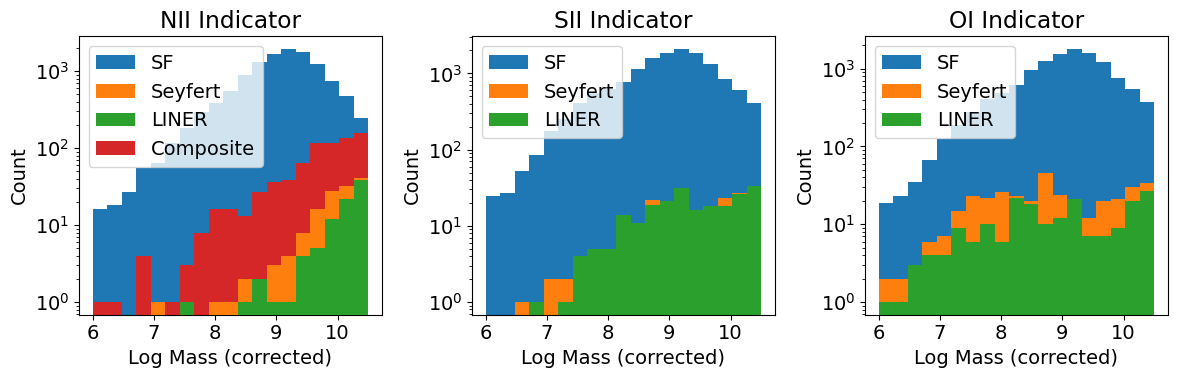

In [111]:
# Define boolean masks for all AGN indicators
is_nii_sf = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SF != 0)
is_nii_sy = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_SY != 0)
is_nii_lin = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_LINER != 0)
is_nii_comp = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.NII_COMP != 0)
is_sii_sf = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.SII_SF != 0)
is_sii_sy = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.SII_SY != 0)
is_sii_lin = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.SII_LINER != 0)
is_oi_sf = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.OI_SF != 0)
is_oi_sy = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.OI_SY != 0)
is_oi_lin = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.OI_LINER != 0)

# Set up common parameters
mbins = np.linspace(6., 10.5, 20)
masskey = 'logmass_zcorrected'

# Create figure with three subplots
fig, axarr = plt.subplots(1, 3, figsize=(12, 4))

# Panel 1: NII indicator
ek.hist(cat.loc[is_nii_sf, masskey], bins=mbins, label='SF', ax=axarr[0])
ek.hist(cat.loc[is_nii_sy, masskey], bins=mbins, label='Seyfert', ax=axarr[0], zorder=3)
ek.hist(cat.loc[is_nii_lin, masskey], bins=mbins, label='LINER', ax=axarr[0], zorder=4)
ek.hist(cat.loc[is_nii_comp, masskey], bins=mbins, label='Composite', ax=axarr[0],zorder=2)
axarr[0].set_yscale('log')
axarr[0].legend()
axarr[0].set_title('NII Indicator')
axarr[0].set_xlabel('Log Mass (corrected)')
axarr[0].set_ylabel('Count')

# Panel 2: SII indicator
ek.hist(cat.loc[is_sii_sf, masskey], bins=mbins, label='SF', ax=axarr[1])
ek.hist(cat.loc[is_sii_sy, masskey], bins=mbins, label='Seyfert', ax=axarr[1])
ek.hist(cat.loc[is_sii_lin, masskey], bins=mbins, label='LINER', ax=axarr[1])
axarr[1].set_yscale('log')
axarr[1].legend()
axarr[1].set_title('SII Indicator')
axarr[1].set_xlabel('Log Mass (corrected)')
axarr[1].set_ylabel('Count')

# Panel 3: OI indicator
ek.hist(cat.loc[is_oi_sf, masskey], bins=mbins, label='SF', ax=axarr[2])
ek.hist(cat.loc[is_oi_sy, masskey], bins=mbins, label='Seyfert', ax=axarr[2])
ek.hist(cat.loc[is_oi_lin, masskey], bins=mbins, label='LINER', ax=axarr[2])
axarr[2].set_yscale('log')
axarr[2].legend()
axarr[2].set_title('OI Indicator')
axarr[2].set_xlabel('Log Mass (corrected)')
axarr[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [119]:
# Select all galaxies with ANY AGN diagnostic from ALL available methods
# (composite, LINER, intermediate, seyfert, AGN, strong AGN, weak AGN)

# All AGN-related flags from the complete diagnostic set
agn_flags = (
    # NII BPT AGN types
    OPT_UV_TYPE.NII_COMP | OPT_UV_TYPE.NII_SY | OPT_UV_TYPE.NII_LINER |
    # SII BPT AGN types  
    OPT_UV_TYPE.SII_SY | OPT_UV_TYPE.SII_LINER |
    # OI BPT AGN types
    OPT_UV_TYPE.OI_SY | OPT_UV_TYPE.OI_LINER |
    # WHAN AGN types
    OPT_UV_TYPE.WHAN_SAGN | OPT_UV_TYPE.WHAN_WAGN |
    # Blue diagram AGN types
    OPT_UV_TYPE.BLUE_AGN | OPT_UV_TYPE.BLUE_LINER | OPT_UV_TYPE.BLUE_SFAGN |
    # Mass-excitation AGN types
    OPT_UV_TYPE.MEX_AGN | OPT_UV_TYPE.MEX_INTERM |
    # Kinematics-excitation AGN types
    OPT_UV_TYPE.KEX_AGN | OPT_UV_TYPE.KEX_INTERM |
    # He II BPT AGN
    OPT_UV_TYPE.HEII_AGN |
    # Ne V AGN
    OPT_UV_TYPE.NEV_AGN
)

# Select galaxies with ANY AGN diagnostic
is_any_agn = (cat['OPT_UV_TYPE'] & agn_flags) != 0

# Alternative breakdown by diagnostic type for analysis:
is_bpt_agn = (cat['OPT_UV_TYPE'] & (
    OPT_UV_TYPE.NII_COMP | OPT_UV_TYPE.NII_SY | OPT_UV_TYPE.NII_LINER |
    OPT_UV_TYPE.SII_SY | OPT_UV_TYPE.SII_LINER |
    OPT_UV_TYPE.OI_SY | OPT_UV_TYPE.OI_LINER
)) != 0

is_bpt_seyfert = (cat['OPT_UV_TYPE'] & (
    OPT_UV_TYPE.NII_SY | OPT_UV_TYPE.SII_SY | OPT_UV_TYPE.OI_SY
)) != 0

is_whan_agn = (cat['OPT_UV_TYPE'] & (
    OPT_UV_TYPE.WHAN_SAGN | OPT_UV_TYPE.WHAN_WAGN
)) != 0

is_blue_agn = (cat['OPT_UV_TYPE'] & (
    OPT_UV_TYPE.BLUE_AGN | OPT_UV_TYPE.BLUE_LINER | OPT_UV_TYPE.BLUE_SFAGN
)) != 0

is_mex_agn = (cat['OPT_UV_TYPE'] & (
    OPT_UV_TYPE.MEX_AGN | OPT_UV_TYPE.MEX_INTERM
)) != 0

is_kex_agn = (cat['OPT_UV_TYPE'] & (
    OPT_UV_TYPE.KEX_AGN | OPT_UV_TYPE.KEX_INTERM
)) != 0

is_heii_agn = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.HEII_AGN) != 0

is_nev_agn = (cat['OPT_UV_TYPE'] & OPT_UV_TYPE.NEV_AGN) != 0

# Add AGN flag columns to the dataframe
cat['is_any_agn'] = is_any_agn
cat['is_bpt_agn'] = is_bpt_agn
cat['is_bpt_seyfert'] = is_bpt_seyfert
cat['is_whan_agn'] = is_whan_agn
cat['is_blue_agn'] = is_blue_agn
cat['is_mex_agn'] = is_mex_agn
cat['is_kex_agn'] = is_kex_agn
cat['is_heii_agn'] = is_heii_agn
cat['is_nev_agn'] = is_nev_agn

print(f"Total galaxies with any AGN diagnostic: {is_any_agn.sum()}")
print(f"BPT AGN (NII/SII/OI): {is_bpt_agn.sum()}")
print(f"WHAN AGN: {is_whan_agn.sum()}")
print(f"Blue diagram AGN: {is_blue_agn.sum()}")
print(f"Mass-excitation AGN: {is_mex_agn.sum()}")
print(f"Kinematics-excitation AGN: {is_kex_agn.sum()}")
print(f"He II AGN: {is_heii_agn.sum()}")
print(f"Ne V AGN: {is_nev_agn.sum()}")
print(f"Fraction of total sample with AGN: {is_any_agn.sum() / len(cat):.3f}")

Total galaxies with any AGN diagnostic: 9952
BPT AGN (NII/SII/OI): 1996
WHAN AGN: 4275
Blue diagram AGN: 4922
Mass-excitation AGN: 1183
Kinematics-excitation AGN: 817
He II AGN: 107
Ne V AGN: 328
Fraction of total sample with AGN: 0.306


In [120]:
cat.to_parquet('../local_data/inputs/agnqso_desi_merianmatched.parquet')